In [13]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
data=pd.read_csv('../chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [15]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [16]:
data['Volume'] = data['Volume'].astype(float)

In [17]:
X=data.iloc[:,:-1]
y=data.iloc[:,5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y) 

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [19]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape) 

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [20]:
class biLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biLSTM, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, bidirectional=True, batch_first=True) 
        self.fc =  nn.Linear(hidden_size*2, num_classes) 
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))                 
        out, _ = self.lstm(x, (h_0, c_0)) 
        out = self.fc(out[:, -1, :])               
        out = self.relu(out)
        return out

In [21]:
num_epochs = 1000 
learning_rate = 0.0001 

input_size = 5 
hidden_size = 2 
num_layers = 1 

num_classes = 1 
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) 

criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [22]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f) 
    optimizer.zero_grad() 
 
    loss = criterion(outputs, y_train_tensors) 
    loss.backward()  
    optimizer.step() 
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.03183
Epoch: 100, loss: 0.02936
Epoch: 200, loss: 0.02765
Epoch: 300, loss: 0.02641
Epoch: 400, loss: 0.02543
Epoch: 500, loss: 0.02460
Epoch: 600, loss: 0.02386
Epoch: 700, loss: 0.02321
Epoch: 800, loss: 0.02260
Epoch: 900, loss: 0.02205


In [23]:
df_x_ss = ss.transform(data.iloc[:, :-1]) 
df_y_ms = ms.transform(data.iloc[:, -1:]) 

df_x_ss = Variable(torch.Tensor(df_x_ss)) 
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1])) 

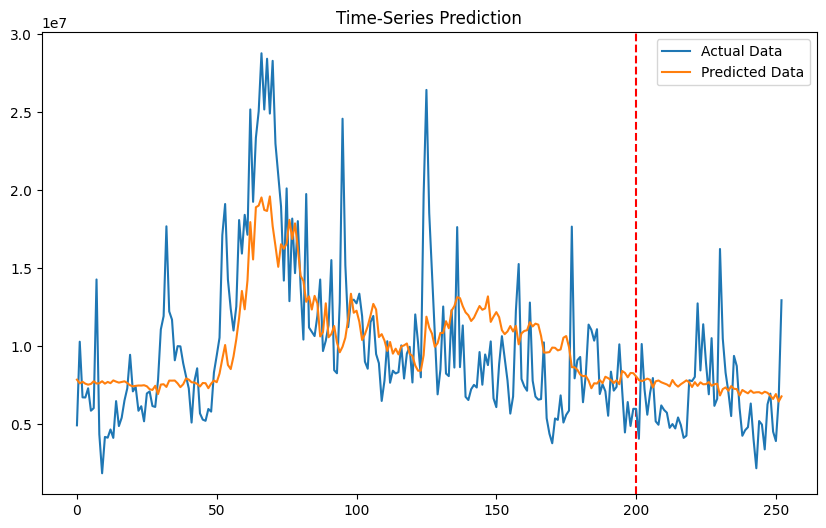

In [24]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted) 
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 